# Test different metrics of surprise
- entropy of 
- KL Divergence
- probabilistic
- distance

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [2]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET

In [3]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [4]:
#dbFile = 'lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'


In [5]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

2000


In [6]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
temp_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            temp_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            temp_scenarios.update(result)    

### Combine temp_scenarios with comb_scenarios
for key, value in temp_scenarios.items():
    if key not in comb_scenarios:
        comb_scenarios[key] = value
    else:
        ### increment the key of temp_scenarios to avoid duplicates
        ### this is a hack, but it works for now
        new_key = key + 1
        comb_scenarios[new_key] = value
        
print(len(comb_scenarios))

3996


In [7]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
temp_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            temp_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            temp_scenarios.update(result)    

### Combine temp_scenarios with comb_scenarios
for key, value in temp_scenarios.items():
    if key not in comb_scenarios:
        comb_scenarios[key] = value
    else:
        ### increment the key of temp_scenarios to avoid duplicates
        ### this is a hack, but it works for now
        new_key = key + 1
        comb_scenarios[new_key] = value
        
print(len(comb_scenarios))

10994


# Get Ladris Roads

In [8]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed

In [452]:
ladris_latlong_dict[328123]

[[-121.1880419, 39.2519689],
 [-121.1879476, 39.2520865],
 [-121.1878389, 39.2522869],
 [-121.187756, 39.252606],
 [-121.1878234, 39.2528889],
 [-121.1878816, 39.2531086],
 [-121.1879835, 39.2533059],
 [-121.188129, 39.2534355],
 [-121.1882818, 39.2535031],
 [-121.1885147, 39.2535482],
 [-121.1887549, 39.2535257],
 [-121.1890532, 39.2534242],
 [-121.189257, 39.2532157],
 [-121.1893226, 39.2529208],
 [-121.1895626, 39.2526606]]

# Get Fleet Roads

In [9]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)
    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    bnode = fleet_link_dict[link_id][1]
    lat_long = fleet_node_dict[bnode]
    fleet_lat_long_dict[segment] = [lat_long[1], lat_long[0]]

In [10]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [11]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,10994.000000,10994.000000,10994.000000
mean,4.173356,250.401355,4.173356
std,1.642942,98.576539,1.642942
min,0.000000,0.000000,0.000000
25%,3.850065,231.003920,3.850065
50%,4.333957,260.037408,4.333957
75%,4.989817,299.389000,4.989817
max,10.857103,651.426167,10.857103


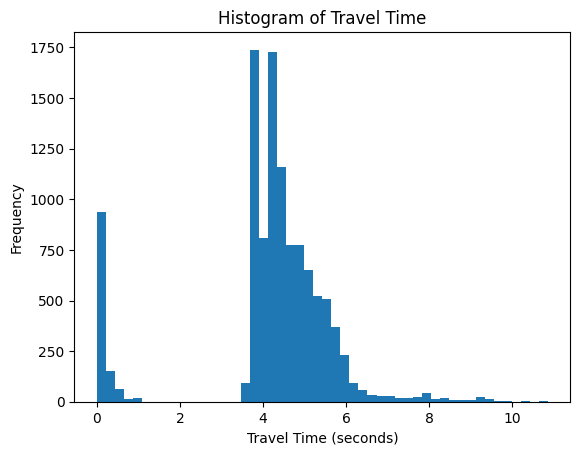

In [12]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results[0], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [13]:
df_results[0]

0        3.678647
1        3.879646
2        3.844590
3        4.652006
4        3.765344
           ...   
10989    4.378647
10990    4.221301
10991    5.565867
10992    4.589829
10993    3.697252
Name: 0, Length: 10994, dtype: float64

In [14]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,7644.000000,7644.000000,7644.000000
mean,4.908016,294.480979,4.908016
std,0.846805,50.808293,0.846805
min,4.000137,240.008193,4.000137
25%,4.300676,258.040543,4.300676
50%,4.680224,280.813469,4.680224
75%,5.254752,315.285093,5.254752
max,10.857103,651.426167,10.857103


In [15]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [16]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    7644.000000
mean        4.908016
std         0.846805
min         4.000137
25%         4.300676
50%         4.680224
75%         5.254752
max        10.857103
dtype: float64

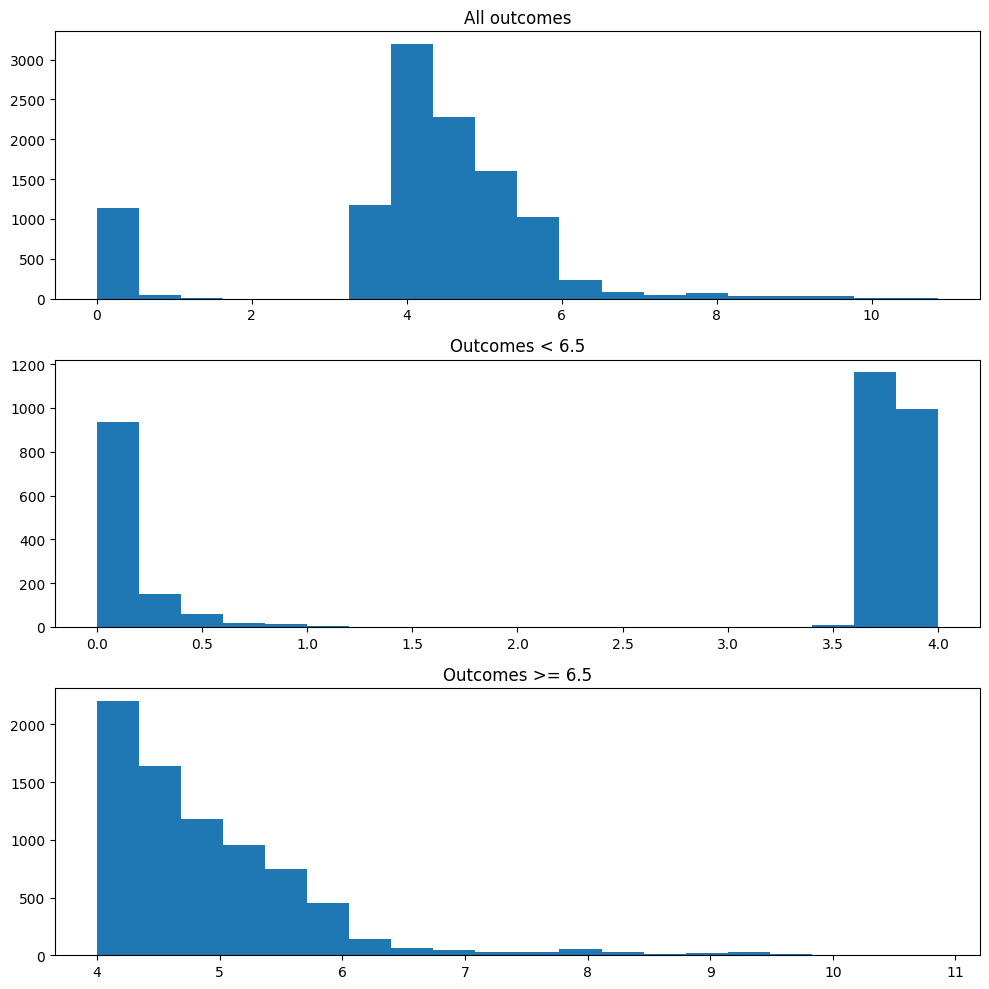

In [17]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# Entropy

/home/pfoytik/.local/lib/python3.10/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


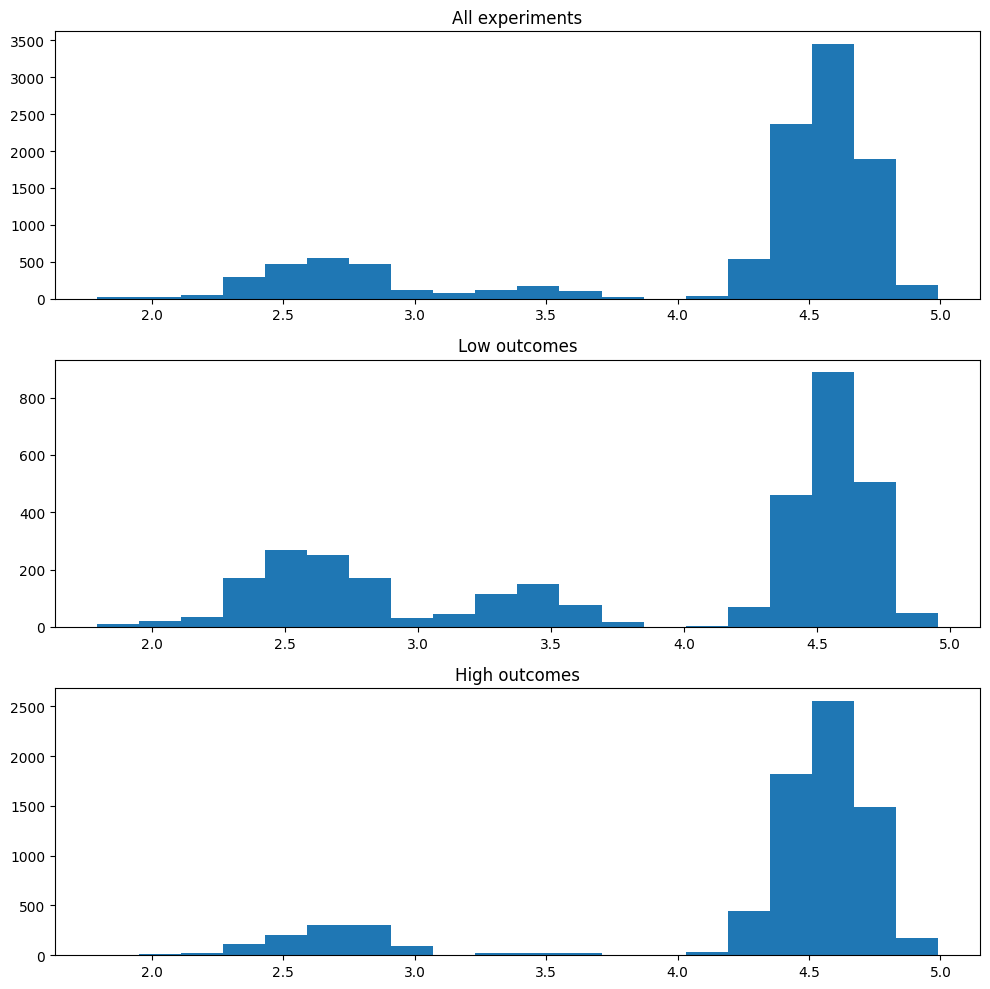

In [18]:
### measure the entropy of each row of df
from scipy.stats import entropy
import numpy as np
entropies = []
lowEntropies = []
highEntropies = []
for i in range(len(experiments)):
    entropies.append(entropy(experiments.iloc[i]))
for i in range(len(lowExperiments)):
    lowEntropies.append(entropy(lowExperiments.iloc[i]))
for i in range(len(highExperiments)):
    highEntropies.append(entropy(highExperiments.iloc[i]))

### create 3 subplots that show the distribution of entropies for all experiments, low outcomes, and high outcomes
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(entropies, bins=20)
ax[0].set_title('All experiments')
ax[1].hist(lowEntropies, bins=20)
ax[1].set_title('Low outcomes')
ax[2].hist(highEntropies, bins=20)
ax[2].set_title('High outcomes')
plt.tight_layout()
plt.show()



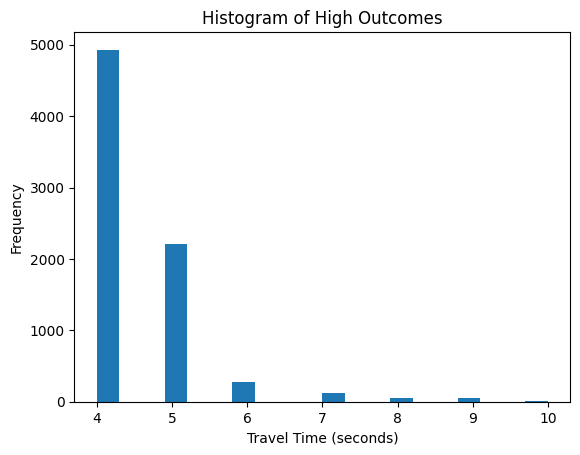

In [30]:
## plot histogram of np.array(highOutcomes, dtype=int)
plt.hist(np.array(highOutcomes, dtype=int), bins=20)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes')
plt.show()

In [291]:
highExperiments.to_numpy().shape[1]

2295

In [295]:
highExperiments

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Compute Info Gain per feature

In [201]:
import numpy as np
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier

def compute_entropy(y):
    """Compute entropy of a binary label distribution."""
    probs = np.bincount(y) / len(y)  # Probabilities of 0 and 1
    return entropy(probs, base=2)

def information_gain(X, y, feature_index):
    """Compute the information gain when splitting on a binary feature."""
    H_before = compute_entropy(y)

    # Split dataset based on feature value (0 or 1)
    y_left = y[X[:, feature_index] == 0]
    y_right = y[X[:, feature_index] == 1]

    # Weighted entropy after split
    H_after = (len(y_left) / len(y)) * compute_entropy(y_left) + \
              (len(y_right) / len(y)) * compute_entropy(y_right)

    return H_before - H_after

# Compute IG for all 200 features
info_gains = np.array([information_gain(highExperiments.to_numpy(), np.array(highOutcomes, dtype=int), i) for i in range(highExperiments.to_numpy().shape[1])])

# Rank features by surprise (higher IG = more surprising)
surprise_ranking = np.argsort(-info_gains)

# Display top 10 surprising features
print("Top 10 surprising features based on entropy reduction:")
for i in surprise_ranking[:10]:
    print(f"Feature {i}: Information Gain = {info_gains[i]:.4f}")


Top 10 surprising features based on entropy reduction:
Feature 109: Information Gain = 0.0238
Feature 304: Information Gain = 0.0208
Feature 92: Information Gain = 0.0181
Feature 106: Information Gain = 0.0163
Feature 83: Information Gain = 0.0159
Feature 97: Information Gain = 0.0122
Feature 108: Information Gain = 0.0104
Feature 82: Information Gain = 0.0080
Feature 1242: Information Gain = 0.0073
Feature 1157: Information Gain = 0.0072


In [202]:
#surprise_ranking[:10]

### print the column title for the top 10 surprising features
for i in surprise_ranking[:20]:
    print(f"Feature {i}: {df.columns[i]}")  # Print the column name for each feature index

Feature 109: 334722
Feature 304: 335412
Feature 92: 329644
Feature 106: 330221
Feature 83: 330512
Feature 97: 329502
Feature 108: 329091
Feature 82: 334420
Feature 1242: 339766
Feature 1157: 330620
Feature 96: 341295
Feature 1284: 330610
Feature 1108: 339914
Feature 1967: 329435
Feature 1123: 340982
Feature 1837: 334719
Feature 366: 330631
Feature 1317: 336214
Feature 90: 342952
Feature 99: 344238


## KL Divergence Method

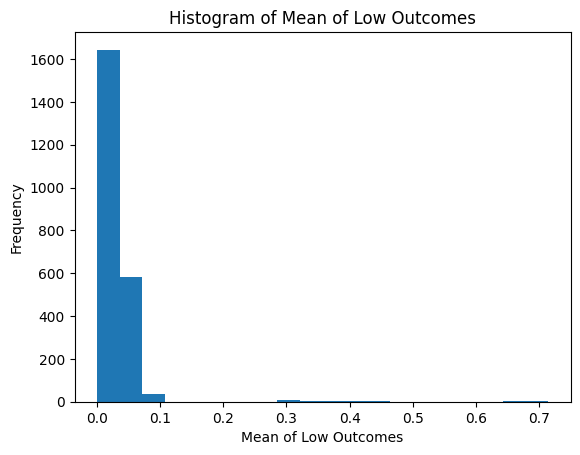

In [74]:
# Plot histogram of np.mean(numHE[numHO > 7], axis=0)) 
plt.hist(np.mean(numHE[numHO>9], axis=0), bins=20)
plt.xlabel('Mean of Low Outcomes')
plt.ylabel('Frequency')
plt.title('Histogram of Mean of Low Outcomes')
plt.show()


In [84]:
from scipy.stats import entropy
import numpy as np

epsilon = 1e-6  # Small smoothing factor to avoid division by zero

numHE = highExperiments.to_numpy()
numHO = np.array(highOutcomes)

# Compute feature frequencies in the full dataset
feature_probs_full = np.mean(df.to_numpy(), axis=0)

# Compute feature frequencies in the critical scenarios dataset
feature_probs_critical = np.mean(numHE[numHO > 5], axis=0)

# Normalize feature probabilities so they sum to 1
feature_probs_full = (feature_probs_full + epsilon) / np.sum(feature_probs_full + epsilon)
feature_probs_critical = (feature_probs_critical + epsilon) / np.sum(feature_probs_critical + epsilon)

threshold = 4
def kl_divergence(p, q):
    """Compute KL divergence between two probability distributions."""
    p = np.clip(p, 1e-10, 1)  # Avoid division by zero
    q = np.clip(q, 1e-10, 1)
    return entropy(p, q, base=2)

# Compute KL divergence for each feature
kl_scores = np.array([kl_divergence([feature_probs_critical[i]], [feature_probs_full[i]]) for i in range(len(feature_probs_full))])

# Rank features by KL divergence (higher means more surprising)
kl_ranking = np.argsort(-kl_scores)

# Top 10 surprising features
print("Top 10 most surprising features by KL divergence:", kl_ranking[:10])


Top 10 most surprising features by KL divergence: [   0 1538 1537 1536 1535 1534 1533 1532 1531 1530]


In [85]:
epsilon = 1e-6  # Small smoothing factor to avoid division by zero

# Normalize feature probabilities so they sum to 1
feature_probs_full = (feature_probs_full + epsilon) / np.sum(feature_probs_full + epsilon)
feature_probs_critical = (feature_probs_critical + epsilon) / np.sum(feature_probs_critical + epsilon)

# Check if they sum to 1 now
print("Sum of feature probabilities (full):", np.sum(feature_probs_full))
print("Sum of feature probabilities (critical):", np.sum(feature_probs_critical))

Sum of feature probabilities (full): 0.9999999999999999
Sum of feature probabilities (critical): 1.0


In [86]:
### print the column title for the top 10 surprising features by KL divergence
for i in kl_ranking[:20]:
    print(f"Feature {i}: {df.columns[i]}")  # Print the column name for each feature index

Feature 0: 328559
Feature 1538: 331747
Feature 1537: 335060
Feature 1536: 331900
Feature 1535: 342918
Feature 1534: 329473
Feature 1533: 330627
Feature 1532: 335159
Feature 1531: 342050
Feature 1530: 339975
Feature 1529: 331514
Feature 1528: 341471
Feature 1527: 338974
Feature 1526: 335468
Feature 1525: 334454
Feature 1524: 334827
Feature 1523: 331606
Feature 1522: 333270
Feature 1508: 331032
Feature 1509: 333092


In [153]:
kl_ranking[:5]

array([   0, 1538, 1537, 1536, 1535])

In [169]:
values5 = df.iloc[:, kl_ranking[:5]].any(axis=1)

In [173]:
### get the rows of df where values5 is True
df.iloc[values5.values].describe()


,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,...,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,0.256865,0.056636,0.055492,0.046911,0.049199,0.057780,0.049199,0.059497,0.054920,0.058924,...,0.012014,0.015446,0.006293,0.017162,0.003432,0.018307,0.014874,0.009153,0.018307,0.021167
std,0.437029,0.231212,0.229004,0.211508,0.216345,0.233394,0.216345,0.236619,0.227889,0.235551,...,0.108978,0.123355,0.079100,0.129914,0.058504,0.134096,0.121084,0.095261,0.134096,0.143982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


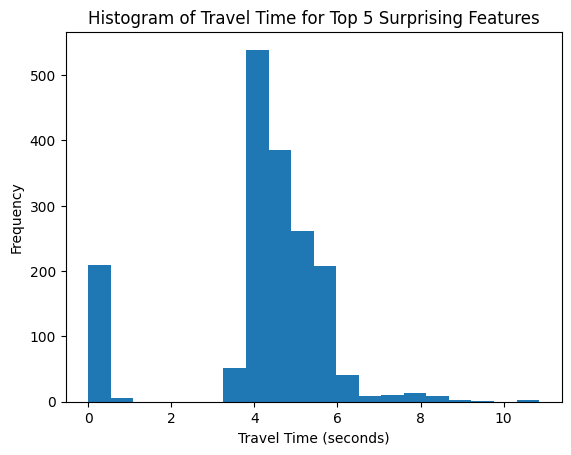

In [174]:
### plot histogram of df_results at indexes of values5
plt.hist(df_results[values5.values][0], bins=20)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time for Top 5 Surprising Features')
plt.show()

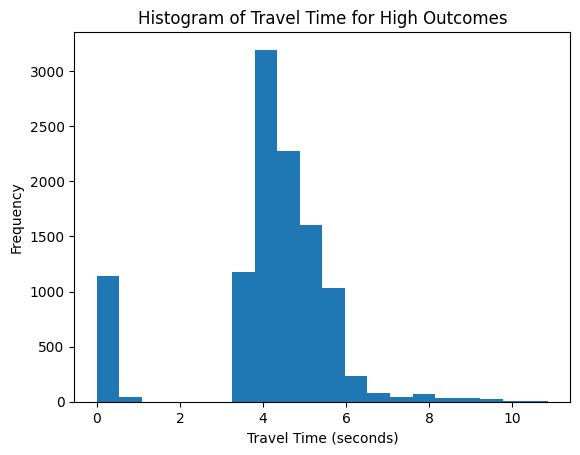

In [178]:
### plot histogram of highOutcomes
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time for High Outcomes')
plt.show()

Filtered DataFrame shape: (1748, 2295)
Filtered DataFrame index: [0, 2000, 2009, 2022, 2025, 2032, 2036, 2037, 2046, 2047, 2048, 2051, 2055, 2056, 2066, 2069, 2073, 2086, 2090, 2093, 2098, 2125, 2126, 2128, 2135, 2137, 2139, 2140, 2141, 2144, 2148, 2151, 2155, 2158, 2170, 2177, 2186, 2188, 2200, 2207, 2214, 2218, 2219, 2230, 2234, 2244, 2245, 2246, 2248, 2253, 2254, 2269, 2274, 2277, 2282, 2283, 2292, 2295, 2299, 2300, 2301, 2303, 2305, 2314, 2317, 2318, 2325, 2328, 2331, 2332, 2334, 2337, 2339, 2343, 2344, 2346, 2352, 2353, 2356, 2360, 2361, 2371, 2378, 2381, 2382, 2392, 2397, 2401, 2402, 2413, 2416, 2420, 2423, 2431, 2436, 2439, 2440, 2441, 2443, 2444, 2448, 2456, 2457, 2463, 2466, 2469, 2471, 2473, 2479, 2488, 2489, 2493, 2506, 2507, 2509, 2512, 2518, 2520, 2521, 2527, 2535, 2537, 2543, 2549, 2560, 2561, 2564, 2578, 2580, 2587, 2594, 2596, 2597, 2603, 2606, 2607, 2611, 2615, 2618, 2622, 2624, 2641, 2648, 2650, 2660, 2662, 2665, 2667, 2668, 2669, 2679, 2680, 2681, 2694, 2696, 2709, 2

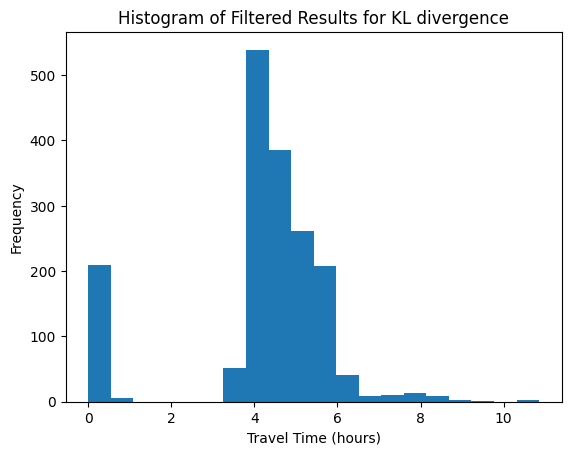

In [151]:
### get all rows of df where any of the kl_ranking[:20] is 1
mask = df.iloc[:, kl_ranking[:5]].any(axis=1)
filtered_df = df[mask]
print("Filtered DataFrame shape:", filtered_df.shape)
### get the index of the filtered_df
filtered_idx = filtered_df.index.tolist()
print("Filtered DataFrame index:", filtered_idx)
### get the index of the filtered_df in df_results
filtered_results_idx = df_results[df_results.index.isin(filtered_idx)].index.tolist()

### plot histogram of filtered_results_idx
plt.hist(df_results.loc[filtered_results_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Results for KL divergence')
plt.show()

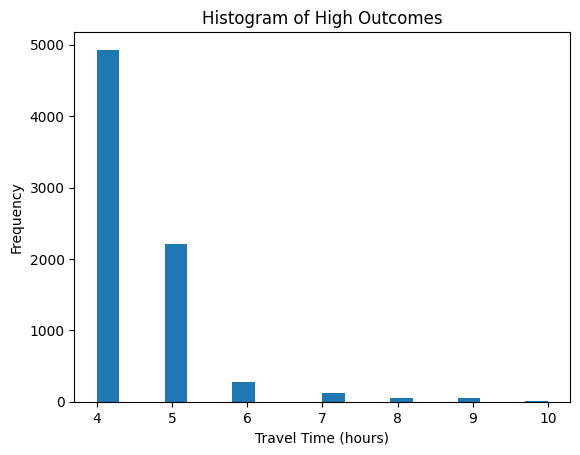

In [113]:
### print histogram of highOutcomes
plt.hist(np.array(highOutcomes, dtype=int), bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes')
plt.show()

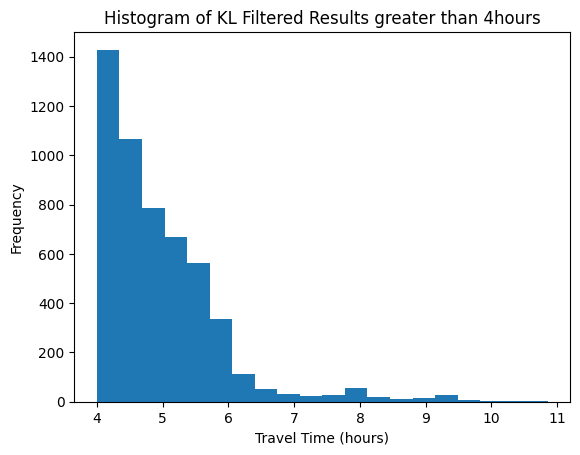

In [150]:
### get the index values of df_results.loc[filtered_results_idx]['hours] that are greater than 4 
mask = df_results.loc[filtered_results_idx]['hours'] > 4
kl_filtered_idx = df_results.loc[filtered_results_idx][mask].index.tolist()
### print histogram of df_results.loc[kl_filtered_idx]['hours']
plt.hist(df_results.loc[kl_filtered_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of KL Filtered Results greater than 4hours')
plt.show()


# Surprise and Critical status
- currently have list of columns with highest critical from an entropy measure with surprise_ranking[:20]
- currently have list of columns with highest surprise from a KL divergence measure with kl_ranking[:20]

How can I collectively get scenarios that are both associated with critical and surprise?



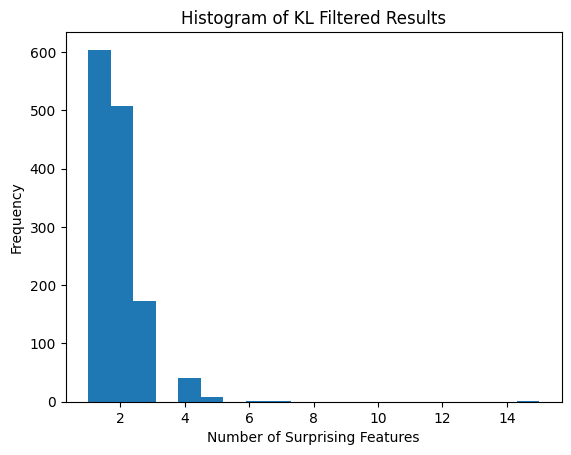

In [122]:
### print the column title for the top 10 surprising features
#for i in surprise_ranking[:20]:
#    print(f"Feature {i}: {df.columns[i]}")  # Print the column name for each feature index

### Column indexes from DF associated with entropy surprise
#surprise_ranking[:20]
### Column indexes from DF associated with KL divergence surprise
#kl_ranking[:20]

### for deach df.loc[kl_filtered_idx] get the number of surpris_ranking[:20] that are 1
kl_filtered_df = df.loc[kl_filtered_idx]

### get the column indexes of kl_ranking[:20]
kl_filtered_df = kl_filtered_df.iloc[:, kl_ranking[:20]]
### get the sum of the rows of kl_filtered_df

kl_filtered_df = kl_filtered_df.sum(axis=1)
### print the histogram of kl_filtered_df
plt.hist(kl_filtered_df, bins=20)
plt.xlabel('Number of Surprising Features')
plt.ylabel('Frequency')
plt.title('Histogram of KL Filtered Results')
plt.show()


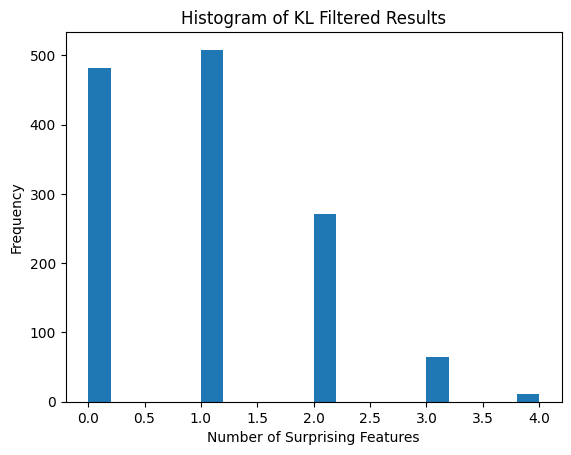

In [131]:
### create a list of all surprise_ranking[:20] that are 1 for each row of df.loc[kl_filtered_idx]
kl_filtered_df = df.loc[kl_filtered_idx]
kl_filtered_df = kl_filtered_df.iloc[:, surprise_ranking[:20]]
### get the sum of the rows of kl_filtered_df
kl_filtered_df = kl_filtered_df.sum(axis=1)
### print the histogram of kl_filtered_df
plt.hist(kl_filtered_df, bins=20)
plt.xlabel('Number of Surprising Features')
plt.ylabel('Frequency')
plt.title('Histogram of KL Filtered Results')
plt.show()


In [147]:
### combine the surprise_ranking[:10] and the kl_ranking[:10] to a new list surprise_critical 
surprise_critical = []
for i in surprise_ranking[:10]:    
    surprise_critical.append(i)
for i in kl_ranking[:10]:
    surprise_critical.append(i)
print(len(surprise_critical))

20


Filtered DataFrame shape: (7549, 2295)
Filtered DataFrame index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,

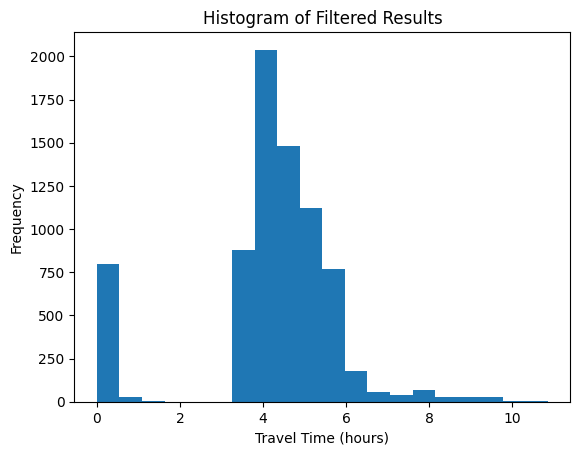

In [149]:
### surprise_critical is the list of column indexes of df that are surprising and critical
### get the rows of df that have values of 1 for any of the columns in surprise_critical
mask = df.iloc[:, surprise_critical].any(axis=1)
filtered_df = df[mask]
print("Filtered DataFrame shape:", filtered_df.shape)
### get the index of the filtered_df
filtered_idx = filtered_df.index.tolist()
print("Filtered DataFrame index:", filtered_idx)
### get the index of the filtered_df in df_results  
filtered_results_idx = df_results[df_results.index.isin(filtered_idx)].index.tolist()
### plot histogram of filtered_results_idx
plt.hist(df_results.loc[filtered_results_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Results')
plt.show()


In [130]:
#### print filtered_df just for the columns defined in kl_ranking[:5]
filtered_df_kl = filtered_df.iloc[:, kl_ranking[:5]]
print("Filtered DataFrame with top 5 KL features:")
filtered_df_kl.describe()

Filtered DataFrame with top 5 KL features:


,328559,331747,335060,331900,342918
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,0.256865,0.243135,0.243135,0.243135,0.114416
std,0.437029,0.429099,0.429099,0.429099,0.318408
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
### print the sum of each column of df.loc[filtered_results_idx]) sorted in descending order
filtered_sum = df.loc[filtered_results_idx].sum().sort_values(ascending=False)
print("Sum of each column of filtered DataFrame (sorted):")
print(filtered_sum)


Sum of each column of filtered DataFrame (sorted):
328559    449
331747    425
331900    425
335060    425
342918    200
         ... 
343404      6
332228      6
343307      5
335527      5
334994      5
Length: 2295, dtype: int64


In [100]:
df_results.loc[filtered_results_idx]

,0,minutes,hours
0,3.678647,220.718833,3.678647
2000,5.709795,342.587700,5.709795
2009,4.534292,272.057532,4.534292
2022,4.042982,242.578950,4.042982
2025,3.888321,233.299258,3.888321
...,...,...,...
10977,4.230386,253.823137,4.230386
10979,4.456025,267.361520,4.456025
10980,4.274643,256.478608,4.274643
10989,4.378647,262.718847,4.378647


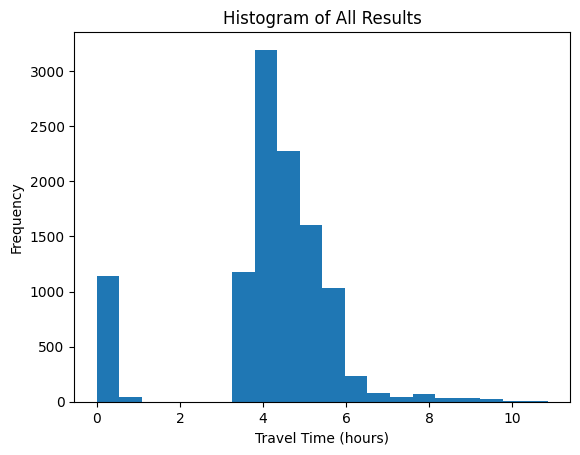

In [97]:
### plot histogram of df_results
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of All Results')
plt.show()

In [91]:
### Measure the number of id's in the top 20 surprising features that are also in the top 20 KL divergence features
top_10_entropy_features = surprise_ranking[:10]
top_10_kl_features = kl_ranking[:10]
common_features = set(top_10_entropy_features).intersection(set(top_10_kl_features))
print(f"Number of common features in top 10 surprising features and top 10 KL divergence features: {len(common_features)}")
### Measure the number of id's in the top 20 surprising features that are also in the top 20 KL divergence features
top_20_entropy_features = surprise_ranking[:100]
top_20_kl_features = kl_ranking[:100]
common_features = set(top_20_entropy_features).intersection(set(top_20_kl_features))
print(f"Number of common features in top 20 surprising features and top 20 KL divergence features: {len(common_features)}")




Number of common features in top 10 surprising features and top 10 KL divergence features: 0
Number of common features in top 20 surprising features and top 20 KL divergence features: 5


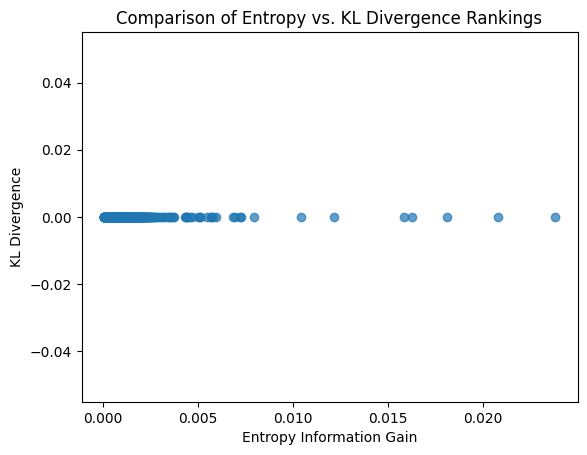

In [92]:
import matplotlib.pyplot as plt

plt.scatter(info_gains, kl_scores, alpha=0.7)
plt.xlabel("Entropy Information Gain")
plt.ylabel("KL Divergence")
plt.title("Comparison of Entropy vs. KL Divergence Rankings")
plt.show()

In [ ]:
### plot entropies against the outcomes for all experiments and for low and high outcomes
plt.figure(figsize=(10, 10))
plt.scatter(lowEntropies, lowOutcomes, label='Low outcomes')
plt.scatter(highEntropies, highOutcomes, label='High outcomes')
plt.xlabel('Entropy')
plt.ylabel('Hours')
plt.legend()
plt.show()



In [ ]:
df.head()

In [ ]:
#### Plot entropies against the outcomes as a boxplot
import seaborn as sns
entropies_df = pd.DataFrame({'Entropy': entropies, 'Outcome': outcomes})
sns.boxplot(x='Outcome', y='Entropy', data=entropies_df)
### Add title
plt.title('Entropy of scenarios against outcomes')
plt.show()


In [ ]:
### remove nan from entropies
entropies = np.array(entropies)
outcomes = np.array(outcomes)
nan_idx = np.isnan(entropies)


### count the number of True in nan_idx
print('Number of nan values in entropies: ', np.sum(nan_idx))

In [ ]:
### print the row of the highest entropy ignoring nan values
print(experiments.iloc[np.nanargmax(entropies)])

### print the sum of the inputs for the row of the highest entropy ignoring nan values
print(experiments.iloc[np.nanargmax(entropies)].sum())

### print the outcome for the row of the highest entropy ignoring nan values
print(outcomes[np.nanargmax(entropies)])


In [ ]:
### print the row of the lowest entropy ignoring nan values
print(experiments.iloc[np.nanargmin(entropies)])

### print the sum of the inputs for the row of the lowest entropy ignoring nan values
print(experiments.iloc[np.nanargmin(entropies)].sum())

### print the outcome for the row of the lowest entropy ignoring nan values
print(outcomes[np.nanargmin(entropies)])

# Bayesian Surprise


In [188]:
### get the index of df_results where df_results['hours'] > 4
idx = df_results[df_results['hours'] > 4].index
### create a df_high with the index of df_results where df_results['hours'] > 4
df_high = df_results.loc[idx]
### get the index of df_results where df_results['hours'] < 4
df.loc[idx].head()


,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
import numpy as np
from scipy.special import betaln, digamma

def bayesian_surprise(feature_counts_total, feature_counts_critical, prior_alpha=1, prior_beta=1):
    """Compute Bayesian surprise using KL divergence between Beta distributions."""
    
    # Total number of samples in both cases
    total_samples = feature_counts_total.sum()
    critical_samples = feature_counts_critical.sum()

    # Compute Alpha & Beta parameters for prior (overall dataset) and posterior (critical cases)
    alpha_0 = prior_alpha + feature_counts_total  # Prior + total feature counts
    beta_0 = prior_beta + (total_samples - feature_counts_total)
    
    alpha_1 = prior_alpha + feature_counts_critical  # Prior + critical feature counts
    beta_1 = prior_beta + (critical_samples - feature_counts_critical)
    
    # Compute KL divergence (Bayesian surprise)
    kl = (
        betaln(alpha_0, beta_0) - betaln(alpha_1, beta_1)
        + (alpha_1 - alpha_0) * digamma(alpha_1)
        + (beta_1 - beta_0) * digamma(beta_1)
        - (alpha_1 + beta_1 - alpha_0 - beta_0) * digamma(alpha_1 + beta_1)
    )
    
    return kl

# Compute feature occurrences in total dataset and critical cases
feature_counts_total = np.sum(df, axis=0)  # How often each feature appears
feature_counts_critical = np.sum(df.loc[idx], axis=0)  # How often each feature appears in critical cases

# Compute Bayesian surprise for all features
bayesian_surprise_values = bayesian_surprise(feature_counts_total, feature_counts_critical)

# Rank features by Bayesian surprise
b_surprise_ranking = np.argsort(-bayesian_surprise_values)  # Higher values = more surprising

print("Top 10 most surprising features:", b_surprise_ranking[:10])


Top 10 most surprising features: 328559    109
330552     84
331652    105
331795     83
332555     86
332843     99
333389    101
333943    104
334433     95
334569    102
dtype: int64


# KL Divergence measure the differnce in distribution between original data and critical data

In [213]:
kl_ranking[:10]

array([   0, 1538, 1537, 1536, 1535, 1534, 1533, 1532, 1531, 1530])

# Bayesian Approach measures how much our belief about feature importance changes when we move from the general population to critical cases
- Measures Change in belief distribution
- Focuses on expectation violation. A feature that is extremely rare in teh general dataset but suddenly appears frequently in critical cases will be very surprising
- Detects anomalies. It highlights features that are unexpectedly important in critical cases, even if they weren't previously considered important
- Bayesian surprise considers shifts in knowledge rather than just information gain (rate of change)
- Think of it as how much your expectations are challenged when observing critical scenarios


In [482]:
b_surprise_ranking.values[:10]

array([109,  84, 105,  83,  86,  99, 101, 104,  95, 102])

# Information Gain Approach measures how much uncertainty is reduced when a feature is known. It tells you which features best split the dataset into different outcome groups (critical)
- Measures Reduction in Uncertainty
- if knowing a feature significantly reduces uncertainty about the outcome, it has high information gain
- really a measure of criticalness and certainty
- Think of it as how much a feature contributes to knowledge rather than how unexpected it is

In [215]:
### Create a dataframe of index values for b_surprise_ranking
surprise_ranking[:10]


array([ 109,  304,   92,  106,   83,   97,  108,   82, 1242, 1157])

In [219]:
for i in b_surprise_ranking.values[:20]:
    print(df.columns[i])  # Print the column name for each feature index

334722
329174
329821
330512
328156
344238
333480
330184
342669
332253
341121
330221
343388
341386
341295
338651
335451
335525
331775
335197


# Calculate Probabilities of inputs

In [ ]:
# Count total occurrences of 1 for each column
column_sums = experiments.sum(axis=0)
lowColumn_sums = lowExperiments.sum(axis=0)
highColumn_sums = highExperiments.sum(axis=0)

column_sums

In [ ]:
### calculate the probability of occurance for each column
column_probs = column_sums / len(experiments)
lowColumn_probs = lowColumn_sums / len(lowExperiments)
highColumn_probs = highColumn_sums / len(highExperiments)

### plot together the sorted probabilities of occurance for all experiments, low outcomes, and high outcomes
plt.plot(column_probs.sort_values(ascending=False).values, label='All experiments probabilities')
plt.plot(lowColumn_probs.sort_values(ascending=False).values, label='Low outcomes probabilities')
plt.plot(highColumn_probs.sort_values(ascending=False).values, label='High outcomes probabilities')
#### label axis
plt.xlabel('Segments')
plt.ylabel('Probability of Occurance')
plt.title('Probability of Occurance for each segment')
plt.legend()
plt.show()



In [ ]:
# Compute co-occurrence matrix (how often each pair of columns is 1 at the same time)
co_occurrence = experiments.T.dot(experiments)
lowCo_occurrence = lowExperiments.T.dot(lowExperiments)
highCo_occurrence = highExperiments.T.dot(highExperiments)

# Compute conditional probabilities
conditional_probabilities = co_occurrence.div(column_sums, axis=1)
lowConditional_probabilities = lowCo_occurrence.div(lowColumn_sums, axis=1)
highConditional_probabilities = highCo_occurrence.div(highColumn_sums, axis=1)

conditional_probabilities

In [ ]:
### convert conditional_probabilities in a dictionary where key is the row and column id and value is the probability

cond_prob_dict = {}
for i in conditional_probabilities.columns:
    for j in conditional_probabilities.index:
        if i != j:
            cond_prob_dict[(i, j)] = conditional_probabilities.loc[i, j]

lowcond_prob_dict = {}
for i in lowConditional_probabilities.columns:
    for j in lowConditional_probabilities.index:
        if i != j:
            lowcond_prob_dict[(i, j)] = lowConditional_probabilities.loc[i, j]

highcond_prob_dict = {}
for i in highConditional_probabilities.columns:
    for j in highConditional_probabilities.index:
        if i != j:
            highcond_prob_dict[(i, j)] = highConditional_probabilities.loc[i, j]        

cond_prob_dict.keys()


In [ ]:
list(cond_prob_dict.keys())[:10]

In [ ]:
### sort the dictionary by values in descending order
sorted_cond_prob_dict = dict(sorted(cond_prob_dict.items(), key=lambda x: x[1], reverse=True))
low_sorted_cond_prob_dict = dict(sorted(lowcond_prob_dict.items(), key=lambda x: x[1], reverse=True))
high_sorted_cond_prob_dict = dict(sorted(highcond_prob_dict.items(), key=lambda x: x[1], reverse=True))

In [ ]:
print(len(sorted_cond_prob_dict), len(low_sorted_cond_prob_dict), len(high_sorted_cond_prob_dict))

In [ ]:
list(sorted_cond_prob_dict.keys())[:10]

In [ ]:
### Plot together the sorted conditional probabilities for all experiments, low outcomes, and high outcomes
plt.plot(list(sorted_cond_prob_dict.values()), label='All experiments conditional probabilities')
plt.plot(list(low_sorted_cond_prob_dict.values()), label='Low outcomes conditional probabilities')
plt.plot(list(high_sorted_cond_prob_dict.values()), label='High outcomes conditional probabilities')
plt.legend()
plt.show()



In [ ]:
### plot 3 subplots of histograms of the conditional probabilities for all experiments, low outcomes, and high outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(list(cond_prob_dict.values()), bins=20)
ax[0].set_title('All experiments probabilities')
ax[1].hist(list(lowcond_prob_dict.values()), bins=20)
ax[1].set_title('Low outcomes experiment probabilities')
ax[2].hist(list(highcond_prob_dict.values()), bins=20)
ax[2].set_title('High outcomes experiment probabilities')
plt.tight_layout()
plt.show()

In [ ]:
### Compare the to top 10 probabilities for all experiments, low outcomes, and high outcomes
print('Top 10 probabilities for all experiments')
print(list(sorted_cond_prob_dict.keys())[:10])
print('Top 10 probabilities for low outcomes')
print(list(lowcond_prob_dict.keys())[:10])
print('Top 10 probabilities for high outcomes')
print(list(highcond_prob_dict.keys())[:10])


In [ ]:
count = 0
### print sorted_cond_prob_dict with values greater than 0.12
for k, v in sorted_cond_prob_dict.items():
    if v > 0.12:
        print(k, v)
        count += 1

print(count)

In [ ]:
count = 0
### print sorted_cond_prob_dict with values less than 0.02
for k, v in sorted_cond_prob_dict.items():
    if v < 0.005 and v > 0.0:
        print(k, v)
        count += 1

print(count)



In [ ]:
# Display the result
print("Conditional Probability Table (P(A | B)):")
print(conditional_probabilities)

In [ ]:
### compare the top ten probabilities of all experiments, low outcomes, and high outcomes
print('Top 10 probabilities for all experiments')
print(list(column_probs.sort_values(ascending=False).index)[:10])
print('Top 10 probabilities for low outcomes')
print(list(lowColumn_probs.sort_values(ascending=False).index)[:10])
print('Top 10 probabilities for high outcomes')
print(list(highColumn_probs.sort_values(ascending=False).index)[:10])


# Feature importance

In [485]:
df_results.describe()

,0,minutes,hours,z
count,10994.000000,10994.000000,10994.000000,10994.000000
mean,4.173356,250.401355,4.173356,0.119562
std,1.642942,98.576539,1.642942,0.193916
min,0.000000,0.000000,0.000000,-0.468511
25%,3.850065,231.003920,3.850065,0.044155
50%,4.333957,260.037408,4.333957,0.127586
75%,4.989817,299.389000,4.989817,0.237267
max,10.857103,651.426167,10.857103,0.842865


In [ ]:
### find feature importance of df for df_results
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Split the data into features and target variable
X = df
y = df_results['z'] > 0.13  # Binary target variable (True if hours > 4, else False)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [488]:
### get the feature importance from the random forest model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]:.4f})")

Feature ranking:
1. Feature 106 (0.0095)
2. Feature 109 (0.0071)
3. Feature 90 (0.0070)
4. Feature 84 (0.0069)
5. Feature 101 (0.0068)
6. Feature 94 (0.0066)
7. Feature 108 (0.0065)
8. Feature 100 (0.0061)
9. Feature 93 (0.0059)
10. Feature 97 (0.0057)
11. Feature 99 (0.0055)
12. Feature 107 (0.0054)
13. Feature 102 (0.0049)
14. Feature 82 (0.0049)
15. Feature 105 (0.0045)
16. Feature 88 (0.0044)
17. Feature 92 (0.0043)
18. Feature 103 (0.0043)
19. Feature 91 (0.0042)
20. Feature 83 (0.0040)
21. Feature 104 (0.0040)
22. Feature 96 (0.0040)
23. Feature 95 (0.0040)
24. Feature 98 (0.0040)
25. Feature 85 (0.0038)
26. Feature 89 (0.0035)
27. Feature 87 (0.0034)
28. Feature 86 (0.0034)
29. Feature 435 (0.0017)
30. Feature 1069 (0.0013)
31. Feature 1417 (0.0012)
32. Feature 1100 (0.0012)
33. Feature 448 (0.0012)
34. Feature 705 (0.0011)
35. Feature 370 (0.0011)
36. Feature 260 (0.0011)
37. Feature 67 (0.0011)
38. Feature 1301 (0.0011)
39. Feature 1768 (0.0010)
40. Feature 195 (0.0010)
41. Fe

In [490]:
### create a data structure that holds the column name and the importance
feature_importance = {}
for i in range(X.shape[1]):
    feature_importance[df.columns[indices[i]]] = importances[indices[i]]
### sort the feature importance by value
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))
### print the top 10 feature importance
print("Top 10 feature importance:")
for k, v in sorted_feature_importance.items():
    print(k, v)

Top 10 feature importance:
330221 0.00947150541265609
334722 0.0071142337689068195
342952 0.0069556329739166155
329174 0.006867424358096814
333480 0.006789865314279751
335451 0.006623685917628935
329091 0.006528251856868236
341386 0.006134254546271511
331775 0.005868586448471539
329502 0.0057077244907768766
344238 0.005506528353711423
335197 0.00543681628471287
332253 0.004918933932832279
334420 0.004858612419961503
329821 0.004468395378558944
338651 0.004407759770109656
329644 0.004280948413516562
343388 0.004259033323379612
334250 0.004216135415599377
330512 0.004027306207465477
330184 0.004022741859553803
341295 0.004008512977245033
342669 0.003963507780136304
341121 0.003954322367542705
335525 0.003759038876233638
336153 0.0034745869236667538
332329 0.003401901519495394
328156 0.003360796843857815
339989 0.0016597444593046524
341340 0.001320821625346866
334916 0.0012014301847622967
335967 0.0011910693769604718
328447 0.0011799128863046488
333423 0.0011168079128577924
344401 0.00110

In [492]:
#export the feature importance to a csv file with 2 columns road_id, importance
import pandas as pd
feature_importance_df = pd.DataFrame(sorted_feature_importance.items(), columns=['road_id', 'importance'])
feature_importance_df.to_csv('ladris_feature_importance.csv', index=False)


In [481]:
### compare the the ranks of probabilities of all experiments, low outcomes, and high outcomes
print('Rank of probabilities for all experiments')
print(column_probs.sort_values(ascending=False).index)



Rank of probabilities for all experiments


NameError: name 'column_probs' is not defined

# Distance of inputs
- use original input as base
- measure distance of every sample input to the original input

Closed roads are special case, as in scenarios with more closed roads are greater distance

This can be resolved by measureing potential of the closed roads with higher surprise on scenarios that have lower potential

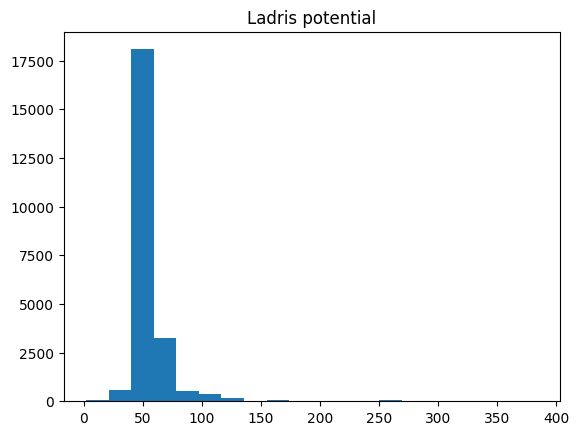

In [220]:
### PLOT histogram of ladris_potential_dict values
plt.hist(list(ladris_potential_dict.values()), bins=20)
plt.title('Ladris potential')
plt.show()

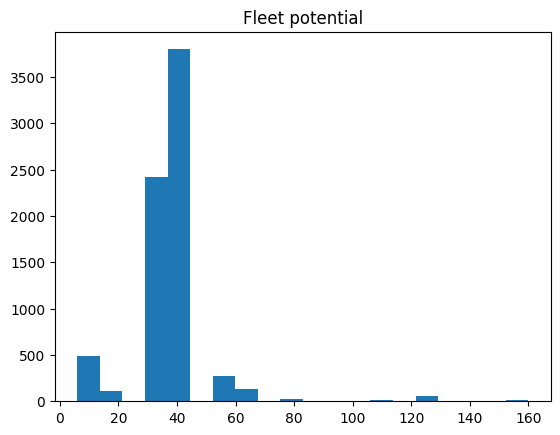

In [221]:
### plot histogram of fleet_potential_dict values
plt.hist(list(fleet_potential_dict.values()), bins=20)
plt.title('Fleet potential')
plt.show()


In [222]:
### get the lowest 10 values of ladris_potential_dict
sorted_ladris = dict(sorted(ladris_potential_dict.items(), key=lambda x: x[1], reverse=False))
### get the lowest 10 values of fleet_potential_dict
sorted_fleet = dict(sorted(fleet_potential_dict.items(), key=lambda x: x[1], reverse=False))

### print the lowest 10 values of ladris_potential_dict
print('Lowest 10 values of ladris')
print(list(sorted_ladris.items())[:10])
### print the lowest 10 values of fleet_potential_dict
print('Lowest 10 values of fleet')
print(list(sorted_fleet.items())[:10])

Lowest 10 values of ladris
[(329971, 2), (330939, 2), (334728, 2), (335769, 2), (336338, 2), (338328, 2), (343106, 2), (337343, 4), (340765, 4), (340361, 6)]
Lowest 10 values of fleet
[('105538099', 6), ('10105538099', 6), ('947888117', 6), ('10947888117', 6), ('947888118', 6), ('10947888118', 6), ('985377673', 6), ('10985377673', 6), ('985377674', 6), ('10985377674', 6)]


In [223]:
for i in data:
    if i['AC91D0B60F78BEFB85DE39CD9C3D2623'] == 329971:
        print(i)

{'ref': 'None', 'name': 'Rattlesnake Road', 'notes': '', 'osmid': 10473307, 'bridge': False, 'oneway': False, 'end_node': 89878988, 'geometry': [[-121.0381033, 39.1651201], [-121.038096, 39.165216], [-121.037906, 39.166294], [-121.0378269, 39.1664426]], 'junction': 'None', 'direction': 0, 'num_lanes': 2, 'road_type': 'arterial', 'speed_mph': 1, 'contraflow': False, 'is_blocked': False, 'is_private': False, 'start_node': 89905780, 'length_meters': 149, 'has_construction': False, 'is_used_in_modeling': True, 'AC91D0B60F78BEFB85DE39CD9C3D2623': 329971}


In [224]:
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

for child in root:
    if child.find('Link_ID').text == '105538099':
        print(child.find('ID').text)
        print(child.find('Freeflow_Speed').text)
        print(child.find('Number_of_Lanes').text)

105538099
6
1


In [225]:
print(segment)
print(fleet_segment_dict['105538099'])

11221020562
105538099


In [226]:
fleet_segment_dict.keys()

dict_keys(['10024501172', '10024501173', '24501175', '10024501175', '10024501177', '24501178', '24501184', '10024501184', '24501185', '10024501185', '10024501193', '10024501197', '10024501200', '24501202', '10024501202', '10024501206', '24501207', '24501208', '10024501215', '24501222', '10024501227', '10024501409', '24501420', '24501448', '10024501448', '10024501450', '24501451', '24501452', '24501453', '24501455', '10024501455', '24501459', '10024501459', '24501460', '10024501460', '24501461', '10024501461', '24501464', '10024501464', '10024501465', '24501466', '24501468', '10024501468', '24501469', '10024501469', '24501470', '10024501470', '24501480', '24501483', '10024501483', '24501486', '10024501486', '24501499', '10024501499', '24501500', '10024501500', '24501562', '24501565', '10024501565', '24501567', '24501569', '24501575', '24501576', '10024501577', '10024501579', '24501587', '10024501587', '10024501590', '24501591', '24517700', '10024517700', '24529719', '10024529719', '2452

# Defined High critical segments for LAdris

In [227]:
### ladris_hc is the high critical segments identified from clustering methods
ladris_hc = [334722, 329091, 334420, 329644, 330512, 330221,
       341386, 336153, 338651, 329174, 330184, 329821,
       329502, 344238, 332329, 335525, 341295, 334250,
       332253, 342952, 335197, 333480]

for i in ladris_hc:
    if ladris_potential_dict[i] < 68:
        print(i, ladris_potential_dict[i])


341386 48
336153 48
330184 48
332253 48
342952 48
333480 48


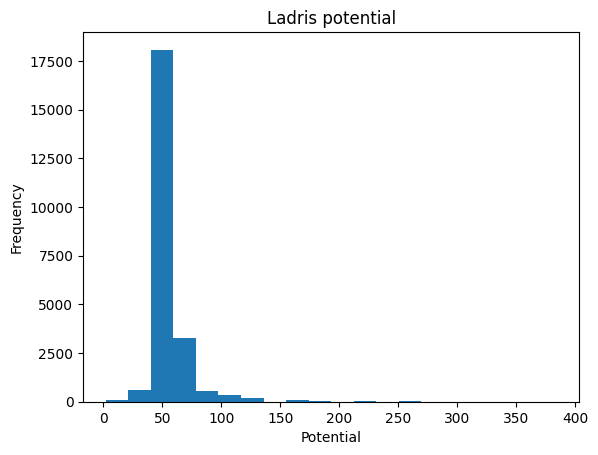

In [228]:
### print histogram of ladris_potential_dict
plt.hist(list(ladris_potential_dict.values()), bins=20)
plt.title('Ladris potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [372]:
### print df where columns are in ladris_hc
df.loc[:, ladris_hc].describe()

,334722,329091,334420,329644,330512,330221,341386,336153,338651,329174,...,329502,344238,332329,335525,341295,334250,332253,342952,335197,333480
count,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,...,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000
mean,0.131344,0.131344,0.131617,0.131526,0.131344,0.129434,0.128979,0.129070,0.131253,0.131526,...,0.131344,0.131253,0.128979,0.124795,0.131526,0.131617,0.129070,0.129161,0.131435,0.108514
std,0.337792,0.337792,0.338090,0.337990,0.337792,0.335695,0.335192,0.335293,0.337693,0.337990,...,0.337792,0.337693,0.335192,0.330502,0.337990,0.338090,0.335293,0.335394,0.337891,0.311042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [375]:
### get all rows of df where columns defined in ladris_hc are 1
lad_hc_filtered_df = df.loc[:,ladris_hc]
lad_hc_filtered_df

,334722,329091,334420,329644,330512,330221,341386,336153,338651,329174,...,329502,344238,332329,335525,341295,334250,332253,342952,335197,333480
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,1,1,1,...,0,0,1,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,1,...,1,1,1,1,1,1,1,0,0,1
3,0,0,0,1,1,1,1,1,1,0,...,1,0,0,1,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
### how many segments have potential less than 50
count = 0
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 50:
        count += 1
### print the total number of segments with potential less than 50 and the total number of segments
print('Total number of segments with potential less than 50: ', count)
### print the total number of segments
print('Total number of segments: ', len(ladris_potential_dict))

Total number of segments with potential less than 50:  17140
Total number of segments:  23248


In [390]:
### get a list of all the segment keys in ladris_potential_dict that have values less than 50
low_potential_segments = []
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 400:
        low_potential_segments.append(i)
### print the number of segments in low_potential_segments
print('Number of segments with potential less than 25: ', len(low_potential_segments))

Number of segments with potential less than 25:  23248


In [387]:
lad_hc_filtered_df.columns

Index([334722, 329091, 334420, 329644, 330512, 330221, 341386, 336153, 338651,
       329174, 330184, 329821, 329502, 344238, 332329, 335525, 341295, 334250,
       332253, 342952, 335197, 333480],
      dtype='int64')

In [388]:
### how many segments in low_potential_segments are in lad_hc_filtered_df
count = 0
lp_evac = []
for i in low_potential_segments:
    if i in lad_hc_filtered_df.columns:
        count += 1
        if i not in lp_evac:
            lp_evac.append(i)
### print the number of segments in low_potential_segments that are in df.columns
print('Number of segments in low_potential_segments that are in df.columns: ', count)

Number of segments in low_potential_segments that are in df.columns:  22


In [394]:
### get rows of df[lp_evac] where any of the columns are 1
lp_evac_df = df.loc[:, lp_evac]

In [395]:
lp_evac_df

,329091,329174,329502,329644,329821,330184,330221,330512,332253,332329,...,334420,334722,335197,335525,336153,338651,341295,341386,342952,344238
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,1,...,1,0,0,1,1,1,0,0,1,0
2,0,1,1,1,1,1,0,0,1,1,...,1,0,0,1,1,0,1,1,0,1
3,0,0,1,1,0,0,1,1,0,0,...,0,0,1,1,1,1,1,1,0,0
4,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10991,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [403]:
### get all the rows of df where any of the columns in lp_evac are 1
#lp_evac_df = df[lp_evac]
### get the index of the lp_evac_df where any of the columns are 1
lp_evac_idx = lp_evac_df[lp_evac_df.any(axis=1)].index
### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[lp_evac_df.any(axis=1)]))


Number of rows in lp_evac_df:  10994
Number of rows in df where any of the columns in lp_evac are 1:  10969
Number of rows in df where any of the columns in lp_evac are 1:  7857


In [402]:
lp_evac_idx

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       10978, 10979, 10981, 10982, 10983, 10986, 10987, 10988, 10989, 10991],
      dtype='int64', length=7857)

In [404]:
### get the index of df_results where values are greater than 4
idx = df_results[df_results['hours'] > 4].index
hc_df = df.loc[idx]

### get the row index of hc_df where any of the columns in lp_evac are 1
hc_evac_idx = hc_df[hc_df.any(axis=1)].index
print(len(hc_evac_idx))


7634


In [405]:
hc_evac_idx

Index([    3,     7,     8,     9,    10,    13,    14,    15,    16,    19,
       ...
       10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992],
      dtype='int64', length=7634)

# Index Definitions
- lp_evacu_idx = index of rows that are low potential
- hc_evac_idx = index of rows that are high critical

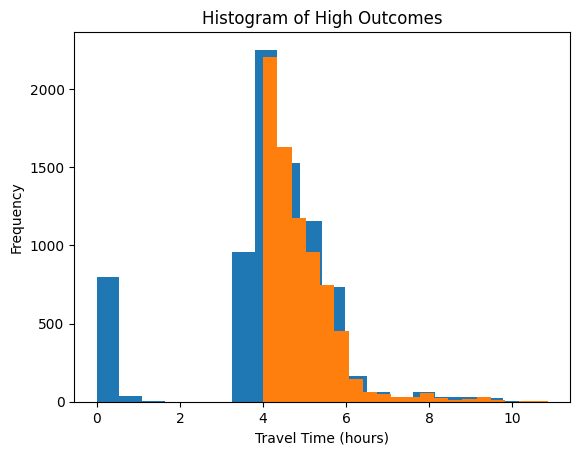

In [406]:
### plot histogram of df_results.loc[hc_evac_idx]['hours'] and df_results.loc[lp_evac_idx]['hours']
plt.hist(df_results.loc[lp_evac_idx]['hours'], bins=20)
plt.hist(df_results.loc[hc_evac_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes')
plt.show()

In [407]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
lp_hc_ladris_results_idx = df_results[df_results['hours'] > 4].index



In [408]:
len(lp_hc_ladris_results_idx)

7644

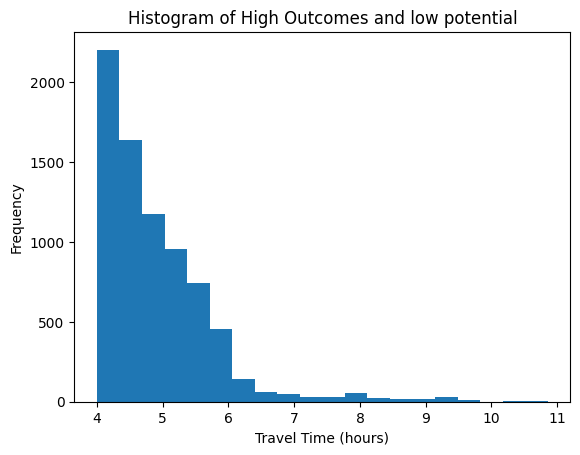

In [410]:
### plot histogram of df_results.loc[lp_hc_ladris_results_idx]['hours']
plt.hist(df_results.loc[lp_hc_ladris_results_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

In [ ]:
### get the df_results where the index is in lp_hc_ladris_results_idx

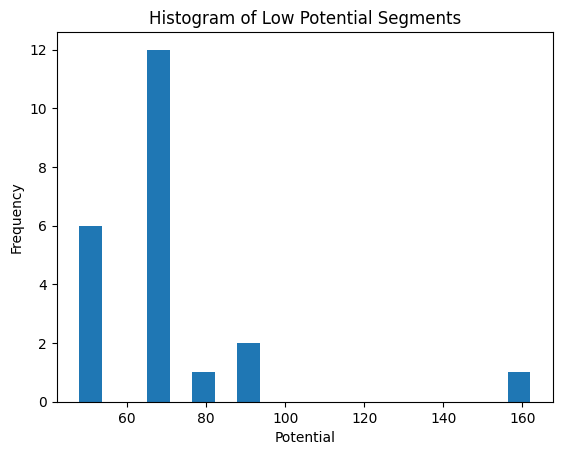

In [411]:
### Plot a histogram of the potential of the segments in lp_evac
plt.hist([ladris_potential_dict[i] for i in lp_evac], bins=20)
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.title('Histogram of Low Potential Segments')
plt.show()

In [416]:
intersect_pot_crit = []
### print the potential of the segments in lp_evac that are less than 80
for i in lp_evac:
    if ladris_potential_dict[i] < 60:
        print(i, ladris_potential_dict[i])
        intersect_pot_crit.append(i)

330184 48
332253 48
333480 48
336153 48
341386 48
342952 48


In [421]:
### get rows of lp_evac_df where any of the columns are in intersect_pot_crit are 1 and are in lp_hc_ladris_results_idx

lp80_hc4_evac_df = lp_evac_df.loc[lp_hc_ladris_results_idx]
### get lp80_hc4_evac_df where any of the columns are in intersect_pot_crit are 1
lp80_hc4_evac_df = lp80_hc4_evac_df.loc[:, intersect_pot_crit]
### get the index of lp80_hc4_evac_df where any of the columns are 1
lp80_hc4_evac_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index

### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp80_hc4_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp_evac_df[lp_evac_df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)]))


Number of rows in lp_evac_df:  7644
Number of rows in df where any of the columns in lp_evac are 1:  7857
Number of rows in df where any of the columns in lp_evac are 1:  2625


Number of rows in lp80_hc4_evac_df:  2625


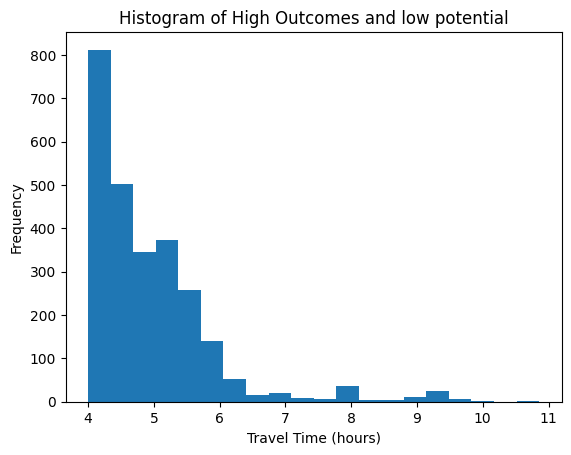

In [422]:
### lp_hc_ladris_results_idx
converged_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index
print('Number of rows in lp80_hc4_evac_df: ', len(converged_idx))
### plot histogram of df_results.loc[converged_idx]['hours']
plt.hist(df_results.loc[converged_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

# The list of segments that are associated with High critical evacuation times and are low on potential
![image.png](images/lp80_hc4.png)

In [426]:
lp80_hc4_evac_df.loc[converged_idx]

,330184,332253,333480,336153,341386,342952
3,0,0,0,1,1,0
7,0,1,0,1,0,0
8,0,0,0,1,0,1
9,0,0,0,0,0,1
10,0,1,1,1,1,1
...,...,...,...,...,...,...
10970,0,0,1,0,0,0
10973,0,0,0,0,0,1
10977,0,0,0,0,1,0
10983,1,0,1,0,0,0


# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [429]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
0,68,78,48,88,68,74,74,88,88,68,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [430]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

/tmp/ipykernel_1592565/3913432881.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)
/tmp/ipykernel_1592565/3913432881.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)


,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,335481,332927,332228,329516,331957,343334,331209,335242,sum,count
0,68,78,48,88,68,74,74,88,88,68,...,0,0,0,0,0,0,0,0,5228,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,852,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1232,21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,910,13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,680,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,48,0,0,0,6717,107
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,48,0,0,0,0,6746,111
10991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,48,0,0,0,0,6722,106
10992,0,0,0,0,0,0,0,0,0,68,...,0,48,0,0,0,0,48,0,5928,99


In [432]:
lam1 = 1
lam2 = 0.5

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot

df_results.head()


,0,minutes,hours,z
0,3.678647,220.718833,3.678647,0.061682
1,3.879646,232.778743,3.879646,0.312172
2,3.844590,230.675400,3.844590,0.288799
3,4.652006,279.120388,4.652006,0.380236
4,3.765344,225.920653,3.765344,0.310762


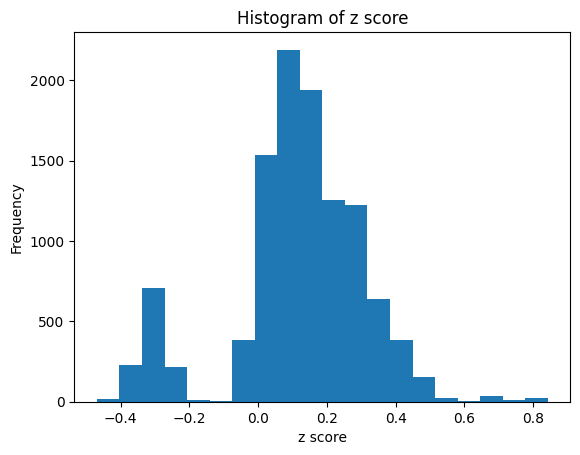

In [433]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [448]:
df.describe()

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
count,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,...,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000,10994.000000
mean,0.040840,0.040931,0.040840,0.040840,0.040931,0.040931,0.040840,0.040840,0.040840,0.040840,...,0.004457,0.011370,0.004548,0.011370,0.002274,0.011370,0.011370,0.006822,0.011370,0.011370
std,0.197929,0.198140,0.197929,0.197929,0.198140,0.198140,0.197929,0.197929,0.197929,0.197929,...,0.066615,0.106026,0.067288,0.106026,0.047634,0.106026,0.106026,0.082316,0.106026,0.106026
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Perform Prim Analysis on df_results and df based on maximizing z

In [445]:
prim_alg = prim.Prim(df, df_results['z'], threshold=0.3, threshold_type='>')
box = prim_alg.find_box()
print(len(box.limits))

34


In [446]:
box.limits

,min,max,qp values
330221,1.0,1.0,0.000000
331850,0.0,0.0,0.000128
339902,0.0,0.0,0.000346
329068,0.0,0.0,0.000346
340776,0.0,0.0,0.000934
339981,0.0,0.0,0.000934
343115,0.0,0.0,0.002523
334470,0.0,0.0,0.002523
331508,0.0,0.0,0.002523
344278,0.0,0.0,0.002523


In [311]:
### calculate information gain for each feature in df.loc[hc_evac_idx]
# Compute IG for all 200 features
#pot_info_gains = np.array([information_gain(df.loc[hc_evac_idx].to_numpy(), np.array(df.loc[hc_evac_idx], dtype=int), i) for i in range(df.loc[hc_evac_idx].to_numpy().shape[1])])
pot_info_gains = np.array([information_gain(df_hc_evac.to_numpy(), np.array(df_hc_eva_results['hours'], dtype=int), i) for i in range(df_hc_evac.to_numpy().shape[1])])

# Rank features by surprise (higher IG = more surprising)
pot_surprise_ranking = np.argsort(-pot_info_gains)

# Display top 10 surprising features
print("Top 10 surprising features based on entropy reduction:")
for i in pot_surprise_ranking[:10]:
    print(f"Feature {i}: Information Gain = {pot_info_gains[i]:.4f}")

Top 10 surprising features based on entropy reduction:
Feature 109: Information Gain = 0.0238
Feature 304: Information Gain = 0.0208
Feature 92: Information Gain = 0.0181
Feature 106: Information Gain = 0.0162
Feature 83: Information Gain = 0.0158
Feature 97: Information Gain = 0.0122
Feature 108: Information Gain = 0.0104
Feature 82: Information Gain = 0.0079
Feature 1242: Information Gain = 0.0073
Feature 1157: Information Gain = 0.0072


In [313]:
pot_surprise_ranking[:10]

array([ 109,  304,   92,  106,   83,   97,  108,   82, 1242, 1157])

In [314]:
surprise_ranking[:10]

array([ 109,  304,   92,  106,   83,   97,  108,   82, 1242, 1157])

In [244]:
### get the rows of df that have values of 1 for any of the columns in low_potential_segments
df[328559]

0        1
1        0
2        0
3        0
4        0
        ..
10989    0
10990    0
10991    0
10992    0
10993    0
Name: 328559, Length: 10994, dtype: int64

In [ ]:
### fleet potential
fleet_hc = ['10091170129', '10116945306', '10116970483', '711443713', '10105537445', '1173061709', '10112051514', '949301691', '10091169783']
for i in fleet_hc:
    if fleet_potential_dict[i] < 54:
        print(i, fleet_potential_dict[i])

In [ ]:
### plot histogram of fleet_potential_dict
plt.hist(list(fleet_potential_dict.values()), bins=20)
plt.title('Fleet potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [326]:
df.head()

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [330]:
ladris_potential_df.loc[hc_evac_idx].head()

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


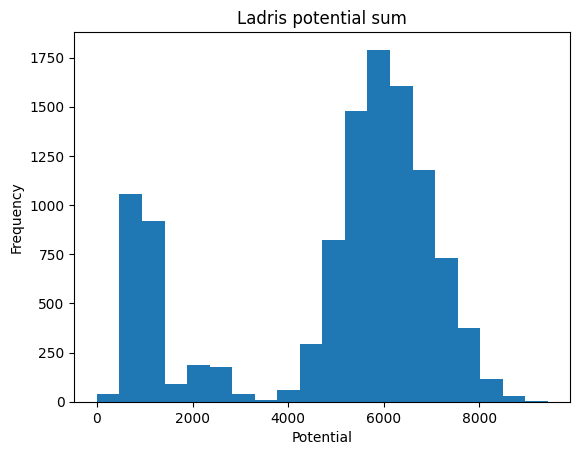

In [332]:
### plot histogram of ladris_potential_df['sum']
plt.hist(ladris_potential_df['sum'], bins=20)
plt.title('Ladris potential sum')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [333]:
### get index values of all rows of ladris_potential_df['sum'] that are less than 4000
lowPotential_idx = ladris_potential_df[ladris_potential_df['sum'] < 4000].index


In [ ]:
### print ladris_potential_df for index values of lowPotential_idx
ladris_potential_df.loc[lowPotential_idx]

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328739,335481,332927,332228,329516,331957,343334,331209,335242,sum
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,852
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1232
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,910
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,680
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,552


In [336]:
ladris_potential_df.loc[lowPotential_idx]

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,335481,332927,332228,329516,331957,343334,331209,335242,sum,count
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,852,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1232,21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,910,13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,680,12
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,552,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
### get index values of all rows of ladris_potential_df.loc[lowPotential_idx] that have a 'count' greater than 0
lowPotential_idx2 = ladris_potential_df.loc[lowPotential_idx][ladris_potential_df['count'] > 0].index

ladris_potential_df.loc[lowPotential_idx2]

/tmp/ipykernel_1592565/4122636981.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lowPotential_idx2 = ladris_potential_df.loc[lowPotential_idx][ladris_potential_df['count'] > 0].index


,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,335481,332927,332228,329516,331957,343334,331209,335242,sum,count
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,852,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1232,21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,910,13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,680,12
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,552,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6902,0,0,48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3736,58
7443,0,0,0,0,0,74,0,0,0,0,...,0,0,0,0,0,0,0,0,3964,65
7511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3947,69
8443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3768,61


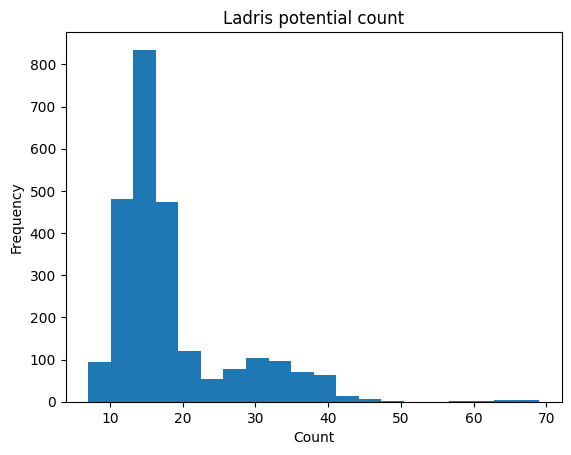

In [339]:
### plot histogram of count for ladris_potential_df.loc[lowPotential_idx2]
plt.hist(ladris_potential_df.loc[lowPotential_idx2]['count'], bins=20)
plt.title('Ladris potential count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

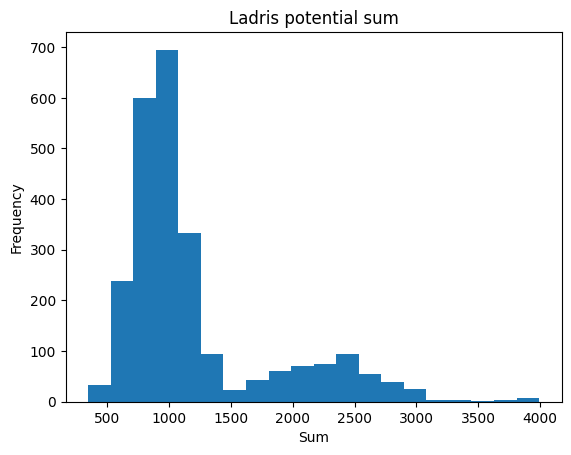

In [340]:
### plot histogram of sum for ladris_potential_df.loc[lowPotential_idx2]
plt.hist(ladris_potential_df.loc[lowPotential_idx2]['sum'], bins=20)
plt.title('Ladris potential sum')
plt.xlabel('Sum')
plt.ylabel('Frequency')
plt.show()



In [341]:
### create a new dataframe from ladris_potential_df.loc[lowPotential_idx2] with the sum and count removed
ladris_potential_df_low = ladris_potential_df.loc[lowPotential_idx2].drop(columns=['sum', 'count'])

ladris_potential_df_low


,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6902,0,0,48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7443,0,0,0,0,0,74,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [367]:
import prim as prim
import numpy as np


In [441]:
x = ladris_potential_df_low
y = ladris_potential_df.loc[lowPotential_idx2]['sum']

prim_alg = prim.Prim(x, y, threshold=2500, threshold_type='>')
box = prim_alg.find_box()
print(len(box.limits))

KeyboardInterrupt: 

In [ ]:
box.limits

,min,max,qp values
329911,0.0,0.0,0.000525
337076,0.0,0.0,0.000525
334728,0.0,0.0,0.003116
331844,0.0,0.0,0.003116
342002,0.0,0.0,0.017662
332815,0.0,0.0,0.017662
341501,0.0,0.0,0.017662
335298,0.0,0.0,0.017662
335265,0.0,0.0,0.040929
333448,0.0,0.0,0.040929


In [463]:
box.limits.index

Index(['330221', '331850', '339902', '329068', '340776', '339981', '343115',
       '334470', '331508', '344278', '329013', '336008', '331036', '343226',
       '335025', '332244', '328558', '330194', '340840', '334729', '340133',
       '329968', '339943', '334661', '335450', '332422', '343048', '328937',
       '328450', '333388', '340154', '336134', '333389', '328547'],
      dtype='object')

In [493]:
df_results.head()

,0,minutes,hours,z
0,3.678647,220.718833,3.678647,0.061682
1,3.879646,232.778743,3.879646,0.312172
2,3.844590,230.675400,3.844590,0.288799
3,4.652006,279.120388,4.652006,0.380236
4,3.765344,225.920653,3.765344,0.310762


In [497]:
### write df to csv and df_results as the last column titled evacuation_time
df['evacuation_time'] = df_results['hours']
### write df to csv
df.to_csv('ladris_df.csv', index=False)
### write df_results to csv
df_results.to_csv('ladris_df_results.csv', index=False)


In [453]:
df.head()

,328559,330552,331652,331795,332555,332843,333389,333943,334433,334569,...,328646,328739,335481,332927,332228,329516,331957,343334,331209,335242
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [496]:
#for i in df.columns:
#    print(ladris_latlong_dict[i][0][0], ladris_latlong_dict[i][-1][1])

### generate csv file of ladris_latlong_dict based on the following columns
#road_id,start_x,start_y,end_x,end_y,capacity,road_type,zone
import csv
with open('ladris_latlong.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['road_id', 'start_x', 'start_y', 'end_x', 'end_y', 'capacity', 'road_type', 'zone'])
    for i in df.columns:
        if i != 'evacuation_time':
            #writeStr = i + ',' + str(ladris_latlong_dict[i][0][0]) + ',' + str(ladris_latlong_dict[i][0][1]) + ',' + str(ladris_latlong_dict[i][-1][0]) + ',' + str(ladris_latlong_dict[i][-1][1]) + ',local,unknown'        
            writer.writerow([i, ladris_latlong_dict[i][0][0], ladris_latlong_dict[i][0][1], ladris_latlong_dict[i][-1][0], ladris_latlong_dict[i][-1][1], 1, "local", "west"])        



In [474]:
### identify the index values of df where box.limits.index values are set to 1
scen_roads = box.limits.index
### convert scen_roads to integers
scen_roads = [int(i) for i in scen_roads]
### get the index values of df where 3 or more columns in scen_roads are 1
index_3plus = []
for i in range(len(df)):
    if df.iloc[i][scen_roads].sum() >= 3:
        print(i)        
        index_3plus.append(i)

print(len(index_3plus))


500
2008
2010
2011
2013
2014
2017
2019
2021
2022
2036
2037
2042
2044
2054
2057
2062
2070
2075
2077
2080
2083
2086
2104
2105
2106
2107
2128
2133
2135
2137
2139
2140
2141
2144
2146
2151
2153
2154
2161
2167
2170
2173
2175
2179
2192
2196
2198
2200
2202
2203
2209
2215
2233
2237
2240
2244
2248
2251
2252
2254
2255
2256
2263
2266
2267
2272
2284
2293
2301
2308
2310
2315
2316
2317
2327
2338
2340
2346
2359
2361
2364
2366
2368
2371
2372
2374
2376
2383
2387
2391
2394
2396
2404
2408
2410
2412
2417
2418
2420
2425
2427
2429
2431
2432
2435
2439
2442
2447
2459
2461
2464
2469
2474
2479
2489
2491
2493
2495
2508
2514
2516
2520
2521
2523
2526
2529
2531
2536
2542
2550
2552
2554
2560
2563
2567
2570
2575
2578
2581
2583
2590
2591
2592
2593
2600
2606
2616
2625
2630
2632
2636
2640
2647
2653
2655
2657
2660
2683
2684
2689
2692
2693
2694
2696
2702
2705
2710
2715
2716
2726
2727
2732
2738
2744
2745
2748
2753
2757
2760
2761
2777
2781
2783
2793
2796
2797
2817
2818
2823
2825
2827
2828
2833
2837
2839
2853
2859
2860
2864
2

In [ ]:
### print the colums of df.iloc[500][scen_roads] that are equal to 1
tempIDS = list(df.iloc[500][scen_roads][df.iloc[500][scen_roads] == 1].index)
### get all the index values of df where tempIDS are 1
tempIDS = [int(i) for i in tempIDS]
### get the index values of df where tempIDS are 1



[328558, 330194, 328937]


In [475]:
 ### create scenario_df.json from df where index is in index_3plus where each row is a distionary of the following structure:
#{
#        "scenario_id": 1,
#        "description": "Major arterial routes blocked",
#        "conditions": [
#            {
#                "road_id": "road_10",
#               "status": "closed"
#            },
#            {
#                "road_id": "road_25",
#                "status": "closed"
#            },
#            {
#                "road_id": "road_42",
#                "status": "closed"
#            }
#        ],
#        "avg_evacuation_time": 112.5,
#        "probability_high_impact": 0.87,
#        "coverage": 0.12
#    }
import json
import pandas as pd
import numpy as np
import csv
import random
import os
import math

scenarios = []
for index in index_3plus:
    # Create a dictionary for the scenario
    scenario = {
        "scenario_id": index,
        "description": "Major arterial routes blocked",
        "conditions": [],
        "avg_evacuation_time": df_results['hours'].iloc[index],
        "probability_high_impact": random.uniform(0.5, 1.0),  # Random value between 0.5 and 1.0
        "coverage": random.uniform(0.1, 0.5)  # Random value between 0.1 and 0.5
    }
    
    # Add conditions based on the columns in scen_roads
    for road in scen_roads:
        if df.iloc[index][road] == 1:
            condition = {
                "road_id": str(road),
                "status": "closed"
            }
            scenario["conditions"].append(condition)
    
    # Append the scenario to the list of scenarios
    scenarios.append(scenario)
# Write the scenarios to a JSON file
with open('scenario_df.json', 'w') as json_file:
    json.dump(scenarios, json_file, indent=4)

